# Imputation des valeurs manquantes

Imputation des valeurs manquantes suite à la sélection des variables réalisées avec le notebook #6

## importation des librairies

In [1]:
import sys
sys.path.insert(0, "../custom_functions")
from model_analysis import plot_confusion_matrix

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.impute import SimpleImputer

## Chargement des données

Les données utilisées ont déjà été retraitées avec imblearn afin d'égaliser les classes par des opérations d'under sampling.

In [13]:
# Load data after undersampling
X_train = pd.read_csv('../data_models/X_train_final.csv',
                     index_col=0)
X_test = pd.read_csv('../data_models/X_test_final.csv',
                     index_col=0)
# Copie des données
X_train_origin = X_train.copy()
X_test_origin = X_test.copy()
# isolation de la target
y_train = X_train['TARGET']
y_test = X_test['TARGET']
X_train = X_train.drop(columns='TARGET')
X_test = X_test.drop(columns='TARGET')

In [4]:
X_train.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education
26449,0.105473,0.063543,249.0,1.0,1686.0,0.909906,0.0,341280.0,10167.0,0.0,0.0
28590,0.472253,0.212280,1775.0,0.0,3314.0,0.798153,183.0,284400.0,11598.0,1.0,0.0
16542,0.547810,0.464989,2467.0,1.0,1161.0,1.026477,25.0,700830.0,15920.0,0.0,0.0
994,0.684828,0.284672,617.0,0.0,6830.0,1.000000,0.0,1042560.0,14970.0,1.0,1.0
31557,NaN,0.587407,1070.0,0.0,349.0,1.000000,2.0,301500.0,12114.0,0.0,0.0


In [9]:
# Nombre de valeurs manquantes par feature
X_train.isnull().sum().sort_values()

CODE_GENDER                                0
AMT_CREDIT                                 0
DAYS_BIRTH                                 0
FLAG_OWN_CAR                               0
NAME_EDUCATION_TYPE_Higher_education       0
EXT_SOURCE_2                              69
PREV_DAYS_DECISION_MIN                   107
INSTAL_DPD_MAX                           116
PREV_APP_CREDIT_PERC_MIN                 134
DAYS_EMPLOYED                           5050
EXT_SOURCE_3                            7042
dtype: int64

Il y a peu de valeurs manquantes sauf pour les features DAYS_EMPLOYED et EXT_SOURCE_3.

In [42]:
# Taille de la matrice des features
X_train.shape

(33492, 11)

In [7]:
# Répartition des classes dans le train set
Counter(y_train)

Counter({1.0: 16700, 0.0: 16792})

In [8]:
# et dans le test set
Counter(y_test)

Counter({1.0: 7223, 0.0: 7131})

## Analyse de la corrélation entre les features

In [43]:
# Extract the EXT_SOURCE variables and show correlations
data_corr = X_train.corr()
data_corr

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education
EXT_SOURCE_3,1.000000,0.152430,0.142065,0.024679,0.143439,0.032725,-0.004710,0.070085,0.221179,-0.009647,0.003210
EXT_SOURCE_2,0.152430,1.000000,0.089441,0.045224,0.125207,-0.011745,0.012685,0.130027,0.130419,0.039412,0.121376
PREV_DAYS_DECISION_MIN,0.142065,0.089441,1.000000,0.026571,0.164362,-0.317444,0.123993,0.100538,0.146895,0.031536,-0.026589
CODE_GENDER,0.024679,0.045224,0.026571,1.000000,0.102069,-0.026695,0.006524,0.007330,0.131700,-0.322336,0.036730
DAYS_EMPLOYED,0.143439,0.125207,0.164362,0.102069,1.000000,-0.049400,0.014898,0.110820,0.349826,-0.020594,0.009777
PREV_APP_CREDIT_PERC_MIN,0.032725,-0.011745,-0.317444,-0.026695,-0.049400,1.000000,-0.042396,-0.032885,-0.041872,-0.000118,0.032193
INSTAL_DPD_MAX,-0.004710,0.012685,0.123993,0.006524,0.014898,-0.042396,1.000000,-0.004156,0.019469,0.002228,-0.007027
AMT_CREDIT,0.070085,0.130027,0.100538,0.007330,0.110820,-0.032885,-0.004156,1.000000,0.099774,0.099262,0.108726
DAYS_BIRTH,0.221179,0.130419,0.146895,0.131700,0.349826,-0.041872,0.019469,0.099774,1.000000,-0.100327,-0.070029
FLAG_OWN_CAR,-0.009647,0.039412,0.031536,-0.322336,-0.020594,-0.000118,0.002228,0.099262,-0.100327,1.000000,0.077193


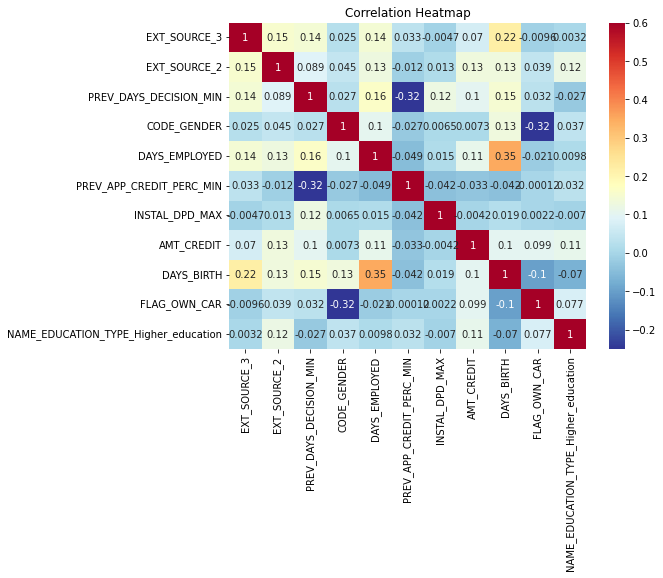

In [44]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(data_corr, cmap = plt.cm.RdYlBu_r,
            vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

## Analyse de la distribution des features

Les features sélectionnées ne sont pas très corrélées entre elles. On obtient une corrélation maximum de 0.35.

In [14]:
# création d'un train set supprimant les valeurs manquantes
X_nonan = X_train_origin.dropna()

In [15]:
# valeurs médianes des features lorsque la target vaut 1
X_nonan[X_nonan['TARGET']==1].median()

EXT_SOURCE_3                                 0.372334
EXT_SOURCE_2                                 0.450417
PREV_DAYS_DECISION_MIN                    1278.000000
CODE_GENDER                                  1.000000
DAYS_EMPLOYED                             1293.000000
PREV_APP_CREDIT_PERC_MIN                     0.867503
INSTAL_DPD_MAX                               3.000000
AMT_CREDIT                              508495.500000
DAYS_BIRTH                               13729.000000
FLAG_OWN_CAR                                 0.000000
NAME_EDUCATION_TYPE_Higher_education         0.000000
TARGET                                       1.000000
dtype: float64

In [16]:
# valeurs médianes des features lorsque la target vaut 0
X_nonan[X_nonan['TARGET']==0].median()

EXT_SOURCE_3                                 0.533482
EXT_SOURCE_2                                 0.572979
PREV_DAYS_DECISION_MIN                    1590.000000
CODE_GENDER                                  1.000000
DAYS_EMPLOYED                             1806.000000
PREV_APP_CREDIT_PERC_MIN                     0.895929
INSTAL_DPD_MAX                               1.000000
AMT_CREDIT                              533304.000000
DAYS_BIRTH                               14735.000000
FLAG_OWN_CAR                                 0.000000
NAME_EDUCATION_TYPE_Higher_education         0.000000
TARGET                                       0.000000
dtype: float64

On observe que les personnes ayant un refus de crédit ont les caractéristiques suivantes:  
- scores EXT_SOURCE_2 et EXT_SOURCE_3 plus faibles  
- période entre la demande de crédit et un crédit précédent plus faible  
- moins d'ancienneté en tant que salarié  
- ratio montant demandé / montant perçu pour le dernier crédit plus faible  
- montant médian du dernier crédit inférieure

### Graphiques de distribution des features

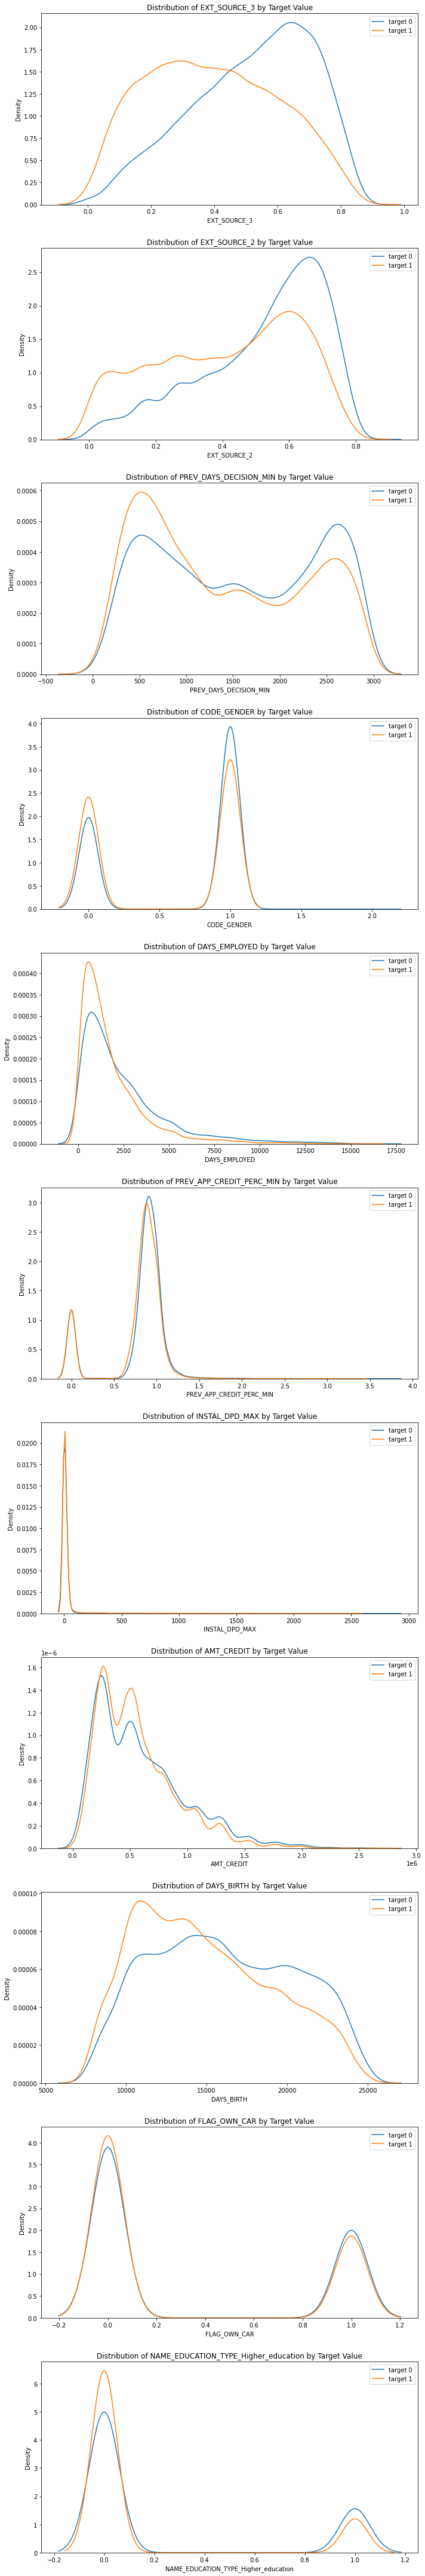

In [21]:
# https://leandeep.com/datalab-kaggle/kb002.html

fig = plt.figure(figsize = (10, 60))
# iterate through the sources
for i, source in enumerate(X_train_origin.columns[:-1]):
    
    # create a new subplot for each source
    plt.subplot(11, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(X_train_origin.loc[X_train_origin['TARGET'] == 0, source])
    # plot loans that were not repaid
    sns.kdeplot(X_train_origin.loc[X_train_origin['TARGET'] == 1, source])
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    plt.legend(labels=['target 0','target 1'])
plt.tight_layout(h_pad = 2.5)
    


## Méthodologie d'impution des valeurs manquantes

Pour certaines variables comme l'ancienneté du poste (DAYS_EMPLOYED), il est difficile de savoir si l'absence de valeur signifie que la personne n'a pas d'emploi / n'est pas salariée ou bien si la donnée n'est pas renseignée. On prendra la seconde hypothèse en prenant soin d'imputer les valeurs manquantes en fonction de la distribution spécifique des classes 0 et 1.

In [22]:
# Séparation du train set en fonction de la target (classes 0 & 1)
X_train0 = X_train_origin[X_train_origin['TARGET']==0]
X_train1 = X_train_origin[X_train_origin['TARGET']==1]

In [24]:
X_test0 = X_test_origin[X_test_origin['TARGET']==0]
X_test1 = X_test_origin[X_test_origin['TARGET']==1]

In [26]:
# Imputation des valeurs manquantes par classe en prenant la valeur la plus fréquente
# observée dans la classe en question (0 ou 1)
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train0_imputed = imputer.fit_transform(X_train0)
X_train1_imputed = imputer.fit_transform(X_train1)
X_test0_imputed = imputer.fit_transform(X_test0)
X_test1_imputed = imputer.fit_transform(X_test1)

In [27]:
# Reconstitution des train & test sets avec classes 0 & 1
X_train_imputed = np.concatenate((X_train0_imputed, X_train1_imputed), axis=0)
X_test_imputed = np.concatenate((X_test0_imputed, X_test1_imputed), axis=0)

In [28]:
# Vérification de la taille du train set
X_train_imputed.shape

(33492, 12)

In [29]:
# Et du test set
X_test_imputed.shape

(14354, 12)

In [32]:
# création des dataframes
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_origin.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_origin.columns)

In [33]:
# Vérification du retraitement des valeurs manquantes
X_train_imputed.isnull().sum()

EXT_SOURCE_3                            0
EXT_SOURCE_2                            0
PREV_DAYS_DECISION_MIN                  0
CODE_GENDER                             0
DAYS_EMPLOYED                           0
PREV_APP_CREDIT_PERC_MIN                0
INSTAL_DPD_MAX                          0
AMT_CREDIT                              0
DAYS_BIRTH                              0
FLAG_OWN_CAR                            0
NAME_EDUCATION_TYPE_Higher_education    0
TARGET                                  0
dtype: int64

In [35]:
X_train_imputed.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,TARGET
0,0.547810,0.464989,2467.0,1.0,1161.0,1.026477,25.0,700830.0,15920.0,0.0,0.0,0.0
1,0.684828,0.284672,617.0,0.0,6830.0,1.000000,0.0,1042560.0,14970.0,1.0,1.0,0.0
2,0.340906,0.682258,1307.0,1.0,1045.0,0.834716,6.0,112500.0,10975.0,0.0,1.0,0.0
3,0.778904,0.750705,2823.0,0.0,8100.0,0.000000,80.0,808650.0,14948.0,1.0,0.0,0.0
4,0.713631,0.419807,422.0,1.0,751.0,0.825616,0.0,509602.5,11680.0,0.0,0.0,0.0


In [36]:
# Sauvegarde des train & test sets après imputation
X_train_imputed.to_csv('../data_models/X_train_imputed.csv')
X_test_imputed.to_csv('../data_models/X_test_imputed.csv')

### Retraitement des données nettoyées avant rebalancement des classes

Les données avant égalisation des classes seront utilisées pour entrainer des modèles lors de la prochaine étape (phase 2). Il est donc important de réaliser les mêmes opérations d'imputatin des variables manqauntes que précédemment.

In [40]:
# Chargement des données avant égalisation des classes
X_top10 = pd.read_csv("../data_models/X_top10.csv", index_col=0)

In [41]:
X_top10.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,TARGET
215169,0.574447,0.092250,1229.0,1.0,335.0,0.627786,0.0,508495.5,20255.0,0.0,0.0,0.0
275171,NaN,0.779680,2688.0,1.0,5862.0,0.906651,0.0,728460.0,21989.0,0.0,0.0,0.0
139526,0.159520,0.475448,1632.0,1.0,NaN,0.938086,0.0,239850.0,25054.0,0.0,0.0,0.0
283387,0.456110,0.698863,2500.0,0.0,7093.0,0.000000,22.0,450000.0,18862.0,0.0,1.0,0.0
14341,0.761026,0.658295,2608.0,1.0,NaN,0.000000,27.0,1350000.0,21817.0,1.0,0.0,0.0


In [42]:
# Séparation des classes
X_top10_0 = X_top10[X_top10['TARGET']==0]
X_top10_1 = X_top10[X_top10['TARGET']==1]

In [43]:
# imputation des valeurs manquantes avec la même méthode que précédemment
X_top10_0_imputed = imputer.fit_transform(X_top10_0)
X_top10_1_imputed = imputer.fit_transform(X_top10_1)

In [44]:
# Reconstitution du dataset avec classes 0 & 1
X_top10_imputed = np.concatenate((X_top10_0_imputed, X_top10_1_imputed), axis=0)

In [45]:
# conversion en dataframe
X_top10_imputed = pd.DataFrame(X_top10_imputed, columns=X_top10.columns)

In [46]:
X_top10_imputed.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,TARGET
0,0.574447,0.092250,1229.0,1.0,335.0,0.627786,0.0,508495.5,20255.0,0.0,0.0,0.0
1,0.746300,0.779680,2688.0,1.0,5862.0,0.906651,0.0,728460.0,21989.0,0.0,0.0,0.0
2,0.159520,0.475448,1632.0,1.0,224.0,0.938086,0.0,239850.0,25054.0,0.0,0.0,0.0
3,0.456110,0.698863,2500.0,0.0,7093.0,0.000000,22.0,450000.0,18862.0,0.0,1.0,0.0
4,0.761026,0.658295,2608.0,1.0,224.0,0.000000,27.0,1350000.0,21817.0,1.0,0.0,0.0


In [47]:
# Vérification des valeurs manquantes
X_top10_imputed.isnull().sum()

EXT_SOURCE_3                            0
EXT_SOURCE_2                            0
PREV_DAYS_DECISION_MIN                  0
CODE_GENDER                             0
DAYS_EMPLOYED                           0
PREV_APP_CREDIT_PERC_MIN                0
INSTAL_DPD_MAX                          0
AMT_CREDIT                              0
DAYS_BIRTH                              0
FLAG_OWN_CAR                            0
NAME_EDUCATION_TYPE_Higher_education    0
TARGET                                  0
dtype: int64

In [48]:
# Sauvegarde des données imputées
X_top10_imputed.to_csv("../data_models/X_top10_imputed.csv")